In [1]:
from os import listdir
from os.path import isfile, join
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import signal



#sns.set(style="darkgrid")

In [2]:
# Code used to explore some of the IGETS data
# Data is publically available, see IGETS group website for details

# http://igets.u-strasbg.fr/

In [3]:
def Noise_Gen(tm,amp):
    noise=[]
    time=[]
    for i in range(tm):
        noise.append(np.random.normal(0,amp))
        time.append(i)
    return np.array(time), np.array(noise)

def Sig_Gen(tm,t0,w,amp):
    s=[]
    t=[]
    for i in range(tm):
        s.append(((np.sqrt(2*np.exp(1)))/w)*amp*(i-t0)*np.exp(-(i-t0)**2/(w**2)))
        t.append(i)
    return np.array(t), np.array(s)


def TS_Correlations_Fast(time,data,kernel):
    output=signal.correlate(data,kernel,mode='same',method='fft')
    return(time,output)

In [5]:
test_dir="C:\\Users\\Rees\\Desktop\\Grav Test\\Level3\\"
test_files=listdir(test_dir)

all_files=[]
for i in range(len(test_files)):
    holder=listdir(test_dir+test_files[i]+"\\")
    holder=[test_files[i]+"\\"+x for x in holder]
    all_files.append(holder)

tests=np.array(all_files)
all_files=tests.flatten()


In [6]:
# # # This checks the Raw data Visually
res_full=np.array([])
for i in range(len(all_files)):
    cur_file=test_dir+all_files[i]
    with open(cur_file) as f:
        content=f.readlines()
        pdtest=pd.Series(content)
        testt=pdtest.str[15:25][18:-2].str.strip().values.astype(np.float)
        res_fil=(1e-9)*testt
        res_full=np.hstack([res_full,res_fil])

tlen=len(res_full)
t=np.array([i for i in range(tlen)])


In [7]:
content

['Filename             : IGETS-SG-RESMIN-cb031-201812r2.ggp\n',
 'Station              : Canberra, Australia\n',
 'Instrument           : GWR C031\n',
 'N Latitude  (deg)    :  -35.32064   0.00001\n',
 'E Longitude (deg)    :  149.00766   0.00001\n',
 'Height (m)           :  762.74900   0.10000\n',
 'Calibration          :  -759.200 &     1.000 from 19970701 to 20181231\n',
 'Processing           : IGETS Central Bureau\n',
 'Author               : jeanpaul.boy@unistra.fr\n',
 'LP tides             : DDW99 + HW95 / FES2014b\n',
 'SP tides             : local model\n',
 'Rotation             : PM + LOD (del=1.16) / Self consistent ocean\n',
 'Atmos. load          : MERRA2/IB + local pressure\n',
 'Drift                : degree-2 polynomial\n',
 'yyyymmdd hhmmss   res_fil res_nofil     tides  rotation  atm_load     drift     g_fil     p_fil\n',
 'C**********************************************************************************************\n',
 'cb031              1.0000    1.0000     0

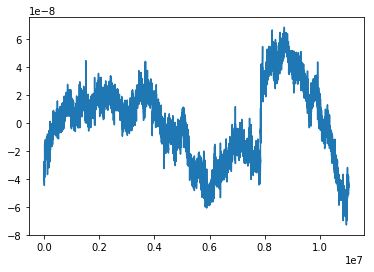

In [13]:
plt.plot(res_full)
plt.show()

C:\Users\Rees\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()


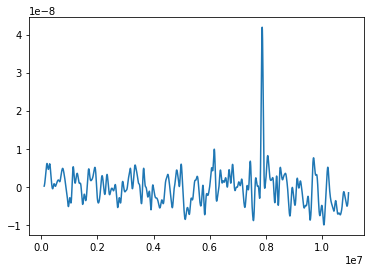

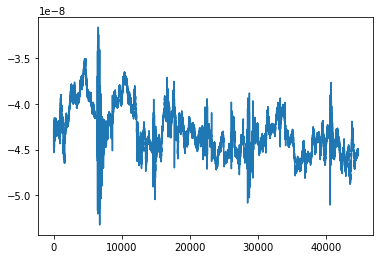

In [14]:
width_vec=[]
max_vec=[]
std_vec=[]
swidth=1

while swidth < 5e4:
    tmask, kernel=Sig_Gen(int(swidth*7),int(swidth*7/2),swidth,1)
    kernel=0.968*np.sqrt(2)*kernel/np.sum(np.abs(kernel))


    tconv,sigconv=TS_Correlations_Fast(t,res_full,kernel)
    max_vec.append(np.max(np.abs(sigconv)))
    std_vec.append(np.std(sigconv))
    width_vec.append(swidth)
    
    swidth=swidth*1.2
    


plt.plot(tconv[2*int(swidth):-2*int(swidth)],sigconv[2*int(swidth):-2*int(swidth)])
plt.show()

plt.plot(res_fil)
plt.show()


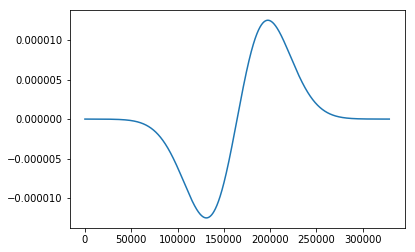

In [15]:
plt.plot(kernel)
plt.show()

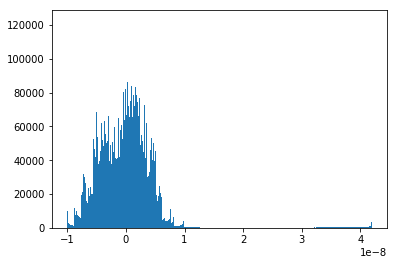

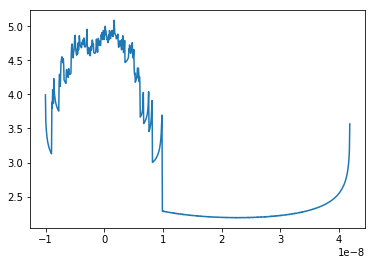

In [16]:
a,b,c=plt.hist(sigconv[2*int(swidth):-2*int(swidth)],bins=800);
plt.show()

plt.plot(b[0:-1],np.log10(a))
plt.show()

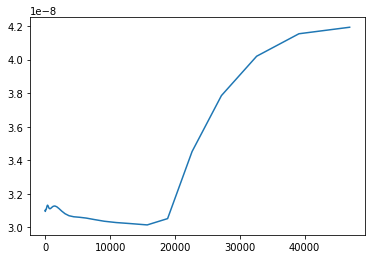

In [17]:
plt.plot(width_vec,max_vec)
plt.show()

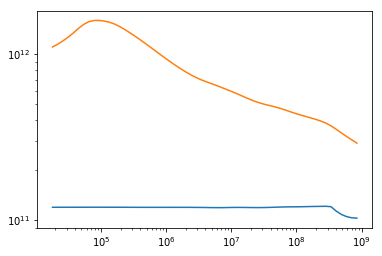

In [18]:
Lambda_Limit=2.1*1e7/np.sqrt(max_vec)
Lambda_Std=2.1*1e7/np.sqrt(std_vec)
dlimit=np.multiply(width_vec,60*300000*1e-3)

plt.loglog(dlimit,Lambda_Limit)
plt.loglog(dlimit,Lambda_Std)
plt.show()